In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from vehicle_list_data import get_vehicles_charging, get_node_totals
import pickle

# Electricity Data

In [8]:
elec_df = pd.read_csv("data_test/Demand_for_California_(region)_hourly_-_UTC_time.csv", skiprows=5, names=["time", "MWH"])
elec_df["utc_time"] = pd.to_datetime(elec_df["time"])
elec_df["local_time"] = elec_df["utc_time"] + pd.Timedelta(hours=-8)

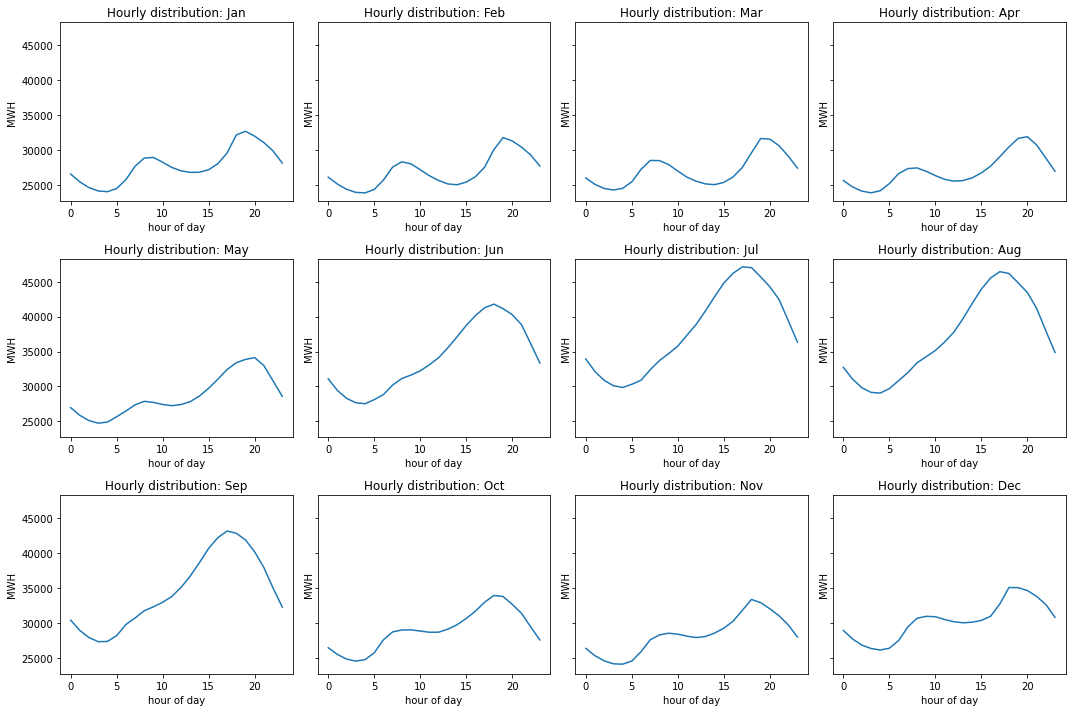

In [23]:
# uncomment the vis you want
# plt.plot(elec_df["MWH"]) # plot entire series
# plt.plot(elec_df[elec_df["local_time"].dt.year==2021]["MWH"]) # plot specific year


# summer_months = [6,7] 
# plt.plot(elec_df[elec_df["local_time"].dt.month.isin(summer_months) & 
#                  elec_df["local_time"].dt.year.isin([2021])]["MWH"]) # plot specific months and years

# elec_df.groupby([elec_df['local_time'].dt.hour, elec_df['local_time'].dt.month]).mean().loc[0] #groupby hours, months

# plot all hourly distributions over months in 2021
elec_df_2021 = elec_df[elec_df['local_time'].dt.year==2021]
fig, axs = plt.subplots(3, 4, sharey=True, figsize=(15,10))
for r in range(3):
    for c in range(4):
        axs[r][c].set_ylabel("MWH")
        axs[r][c].set_xlabel("hour of day")
        axs[r][c].set_title("Hourly distribution: " + datetime.datetime.strptime(str(r*4+c+1), "%m").strftime("%b"))
        axs[r][c].plot(elec_df_2021.groupby([elec_df_2021['local_time'].dt.month, elec_df_2021['local_time'].dt.hour]).mean().loc[r*4+c+1]["MWH"])
fig.tight_layout()

# Volume GIF

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
import pickle

from vehicle_list_data import get_index_edge_totals

In [92]:
############## SET THESE PARAMETERS FIRST ##############
file = "trials/full_day_results/full_day_scenario4_algorithm_7_05_03_2022_22_09_07.pkl"
with open(file, 'rb') as inp:
    sim = pickle.load(inp)
name = "animation_full_day_scenario_4_alg_7"

In [ ]:
G = sim.station_demand_g
edge_totals = get_index_edge_totals(sim)

In [93]:
def set_visual_node_attributes(G):
    for node in G.nodes:
        G.nodes[node]["color"] = "blue"
        G.nodes[node]["size"] = 5
    for node in nx.get_node_attributes(G,'demand'):
        G.nodes[node]["color"] = "green"
        G.nodes[node]["size"] = 20
    return G
G = set_visual_node_attributes(G)

In [95]:
def animate(sim_index):
    node_color = nx.get_node_attributes(G,'color').values() 
    node_size = {node: edge_totals[sim_index][(node, node)] if (node, node) in edge_totals[sim_index] else G.nodes[node]["size"] for node in G.nodes}
    widths = {edge:edge_totals[sim_index][edge]/50 if edge in edge_totals[sim_index] else .002 for edge in G.edges}
    pos = nx.get_node_attributes(G,'pos')
    graph_viz = nx.draw(G, pos = pos, node_size = list(node_size.values()), width= list(widths.values()), node_color=node_color, arrows=False)

MovieWriter avconv unavailable; using Pillow instead.
/Users/alandler/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # This is added back by InteractiveShellApp.init_path()
/Users/alandler/.local/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


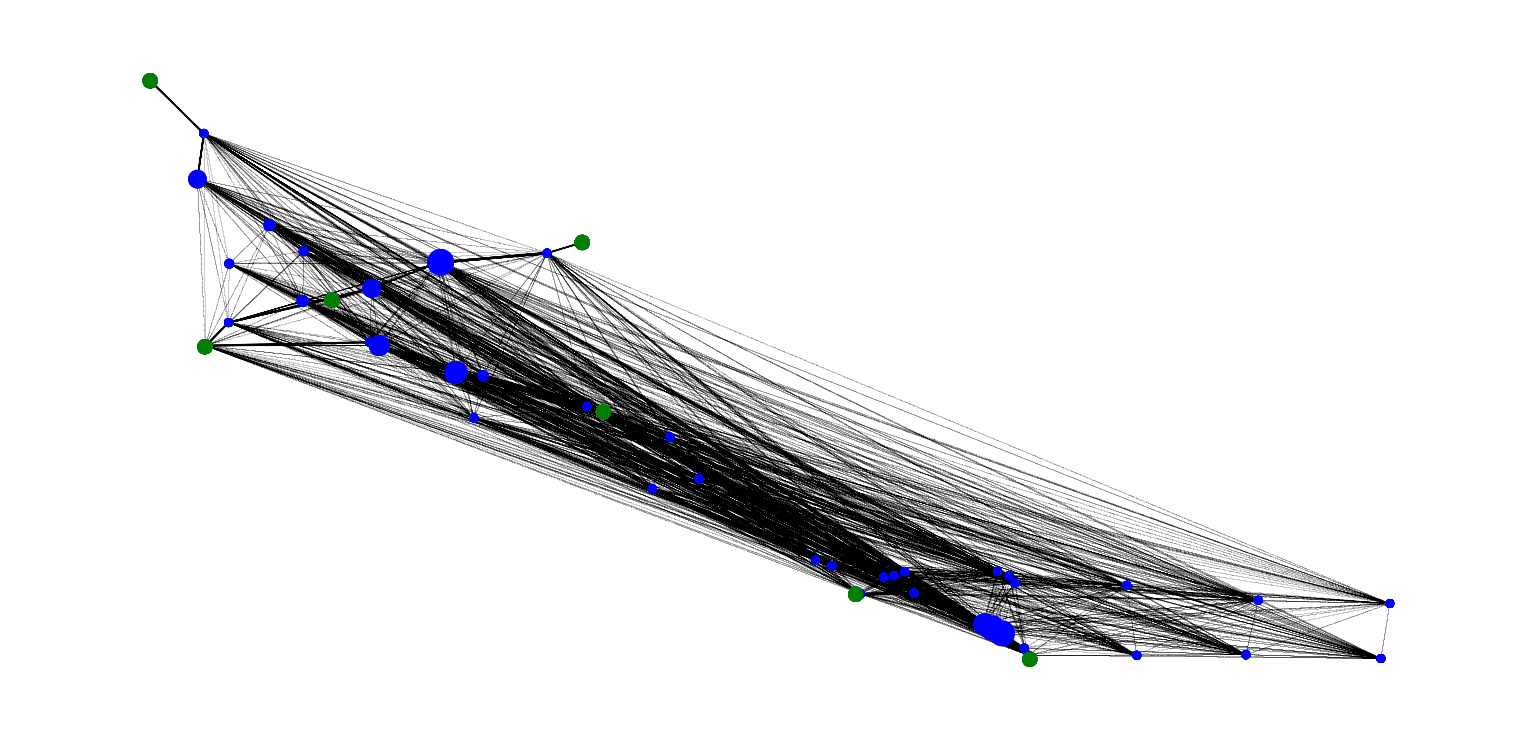

In [97]:
fig = plt.figure(dpi=200)
node_color = nx.get_node_attributes(G,'color').values() 
node_size = {node: edge_totals[sim_index][(node, node)] if (node, node) in edge_totals[sim_index] else G.nodes[node]["size"] for node in G.nodes}
widths = {edge:edge_totals[sim_index][edge]/50 if edge in edge_totals[sim_index] else .002 for edge in G.edges}
pos = nx.get_node_attributes(G,'pos')
graph_viz = nx.draw(G, pos = pos, node_size = list(node_size.values()), width= list(widths.values()), node_color=node_color, arrows=False)

# Animator call
anim = animation.FuncAnimation(fig, animate, frames=24, interval=100, blit=False)
# anim.save('/tmp/animation.gif', writer='imagemagick', fps=30)
anim.save("gifs/" + name + ".gif", fps=5, writer="avconv", codec="libx264")

# Electricity Metric

In [21]:
############## SET THESE PARAMETERS FIRST ##############
file = "trials/full_day_results/full_day_scenario4_algorithm_7_05_03_2022_22_09_07.pkl"
with open(file, 'rb') as inp:
    sim = pickle.load(inp)

In [22]:
# hardcoded to 45 kw chargers
charging_kw = 45
vehicles_charging = get_vehicles_charging(sim)

In [23]:
get_node_totals(sim);

In [24]:
vehicles_charging;

In [25]:
# get vehicles charging at given timestep
vehicles_charging_sim_index = {}
for sim_index in vehicles_charging:
    vehicles_charging_sim_index[sim_index] = sum([vehicles_charging[sim_index][key] for key in vehicles_charging[sim_index]])

In [26]:
vehicles_charging_per_hour = {}
for sim_index in vehicles_charging_sim_index:
    if sim_index//5 not in vehicles_charging_per_hour:
        vehicles_charging_per_hour[sim_index//5] = vehicles_charging_sim_index[sim_index]
    else:
        vehicles_charging_per_hour[sim_index//5] += vehicles_charging_sim_index[sim_index]

In [27]:
electricity_usage_per_hour = {key:vehicles_charging_per_hour[key]*charging_kw for key in vehicles_charging_per_hour}

In [28]:
electricity_usage_per_hour

{0: 0,
 1: 3645,
 2: 12150,
 3: 19170,
 4: 24345,
 5: 27630,
 6: 28710,
 7: 28800,
 8: 28800,
 9: 28800,
 10: 28800,
 11: 28800,
 12: 28800,
 13: 28800,
 14: 28800,
 15: 28800,
 16: 28800,
 17: 28800,
 18: 28800,
 19: 28800,
 20: 28800,
 21: 28800,
 22: 28800,
 23: 28800}